In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

import statsmodels.formula.api as sfa
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
data = pd.concat([train_data,test_data], ignore_index = False)

In [5]:
train_data.shape, test_data.shape, data.shape

((35000, 20), (15000, 19), (50000, 20))

In [8]:
# Univariate Analysis
num_cols = data.select_dtypes(include = np.number).columns
cat_cols = data.select_dtypes(exclude = np.number).columns

In [12]:
num_cols = ['trip_distance', 'rate_code', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge',
       'total_amount', 'trip_duration',
       'calculated_total_amount']

cat_cols = [ 'year','month', 'day', 'day_of_week','store_and_fwd_flag', 'hour_of_day']

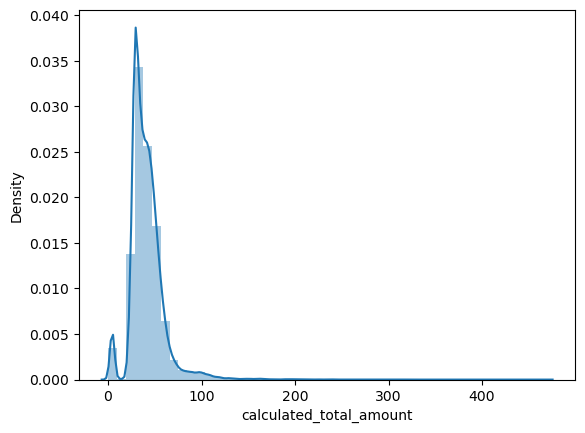

In [14]:
sns.distplot(data['calculated_total_amount']);

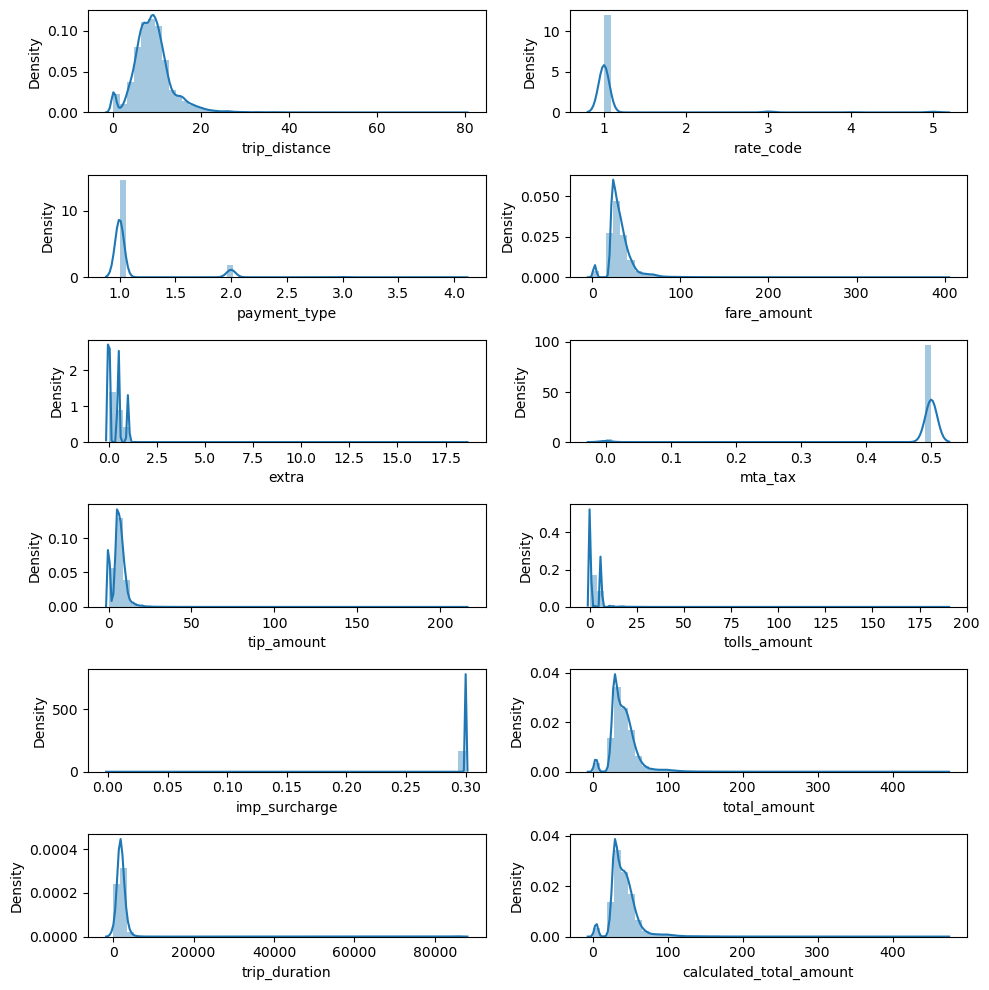

In [17]:
# NUmerical Columns
plt.figure(figsize=(10,10))
j = 1
for i in num_cols:
    plt.subplot(6,2,j);
    sns.distplot(data[i]);
    j += 1
    
plt.tight_layout()
plt.show()

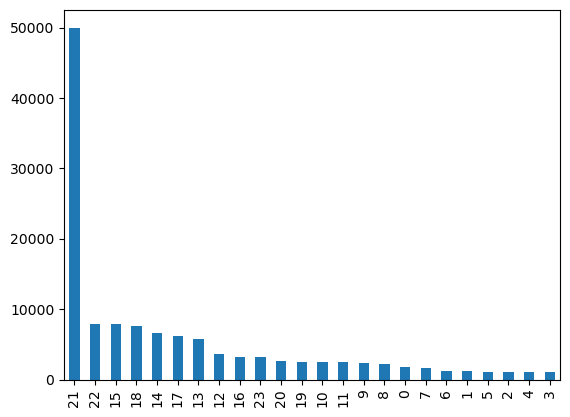

In [39]:
# Categorical data

for i in cat_cols:
    data[i].value_counts().plot(kind = 'bar');

In [40]:
cat_cols

['year', 'month', 'day', 'day_of_week', 'store_and_fwd_flag', 'hour_of_day']

In [18]:
# Missing Values
data.isnull().sum()
# No Missing Values

trip_distance                  0
rate_code                      0
store_and_fwd_flag             0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
imp_surcharge                  0
total_amount                   0
pickup_location_id             0
dropoff_location_id            0
year                           0
month                          0
day                            0
day_of_week                    0
hour_of_day                    0
trip_duration                  0
calculated_total_amount    15000
dtype: int64

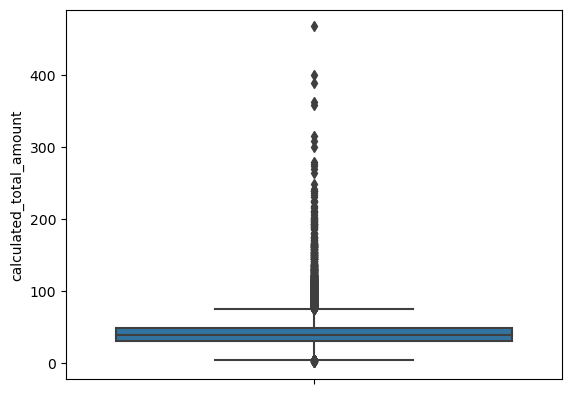

In [32]:
sns.boxplot(y = data['calculated_total_amount']);

In [25]:
# Feature Enginnering
# Amount_Per_Distance
data['amount_per_mile'] = data['total_amount']/data['trip_distance']

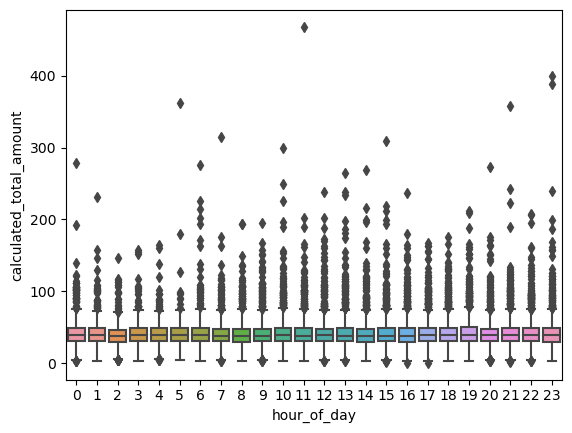

In [31]:
# Number of hours Vs Calculated Total Amount
sns.boxplot(x = data['hour_of_day'], y = data['calculated_total_amount']);
# 5, 6, 7, 10, 11, 13, 14, 15, 16, 20, 21, 23

In [37]:
data['peak_hours'] = data['hour_of_day'].apply(lambda x:1 if x in [5, 6, 7, 10, 11, 13, 
                                              14, 15, 16, 20, 21, 23] else 0)

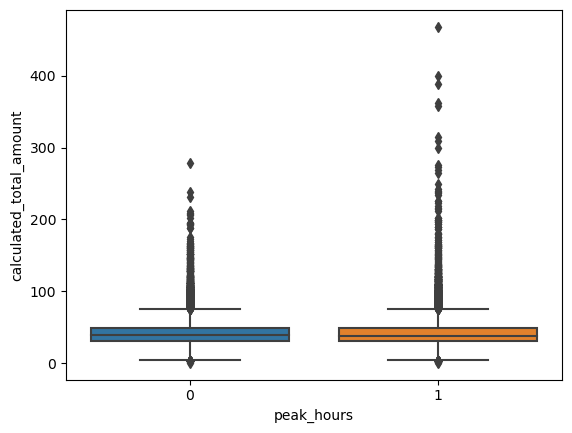

In [38]:
sns.boxplot(x = data['peak_hours'], y = data['calculated_total_amount']);

In [62]:
data['day_mean'] = data.day.map(dict(data.groupby(by = 'day')['total_amount'].describe()['mean']))

In [91]:
data['day_median'] = data.day.map(dict(data.groupby(by = 'day')['total_amount'].describe()['50%']))

In [92]:
data['day_min'] = data.day.map(dict(data.groupby(by = 'day')['total_amount'].describe()['min']))

In [93]:
data['day_max'] = data.day.map(dict(data.groupby(by = 'day')['total_amount'].describe()['max']))

In [107]:
data['month_mean'] = data.month.map(dict(data.groupby(by = 'month')['total_amount'].describe()['mean']))
data['month_median'] = data.month.map(dict(data.groupby(by = 'day')['total_amount'].describe()['50%']))
data['month_min'] = data.month.map(dict(data.groupby(by = 'month')['total_amount'].describe()['min']))
data['month_max'] = data.month.map(dict(data.groupby(by = 'month')['total_amount'].describe()['max']))

In [109]:
data['trip_count'] = data.groupby('pickup_location_id')['dropoff_location_id'].transform('nunique')

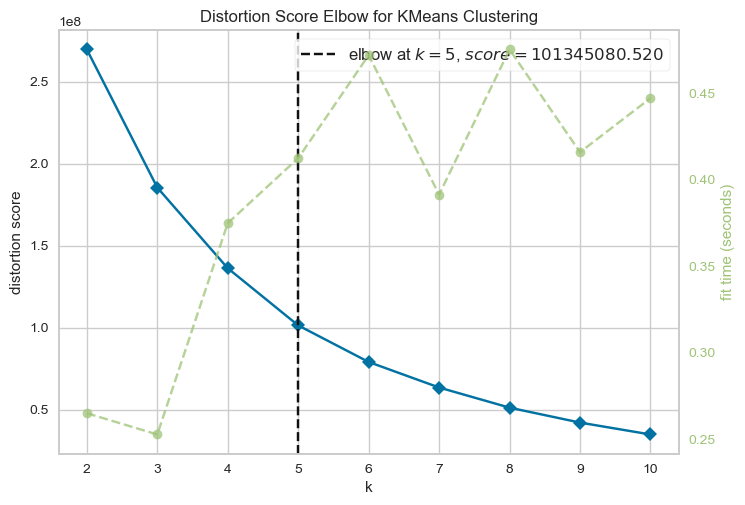

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [112]:
kmeans = KMeans()
visualiser = KElbowVisualizer(estimator = kmeans)

visualiser.fit(data.loc[:,['pickup_location_id','dropoff_location_id']])
visualiser.show()
# open cage --  library, if you have longitude and latitude

In [116]:
# Deploy the KMeans Clustering and Generate Cluster Lables
kmeans = KMeans(n_clusters = 5, random_state =42)
kmeans.fit(data.loc[:,['pickup_location_id','dropoff_location_id']])

kmeans.cluster_centers_ # centroid
data['geo_location'] = kmeans.labels_

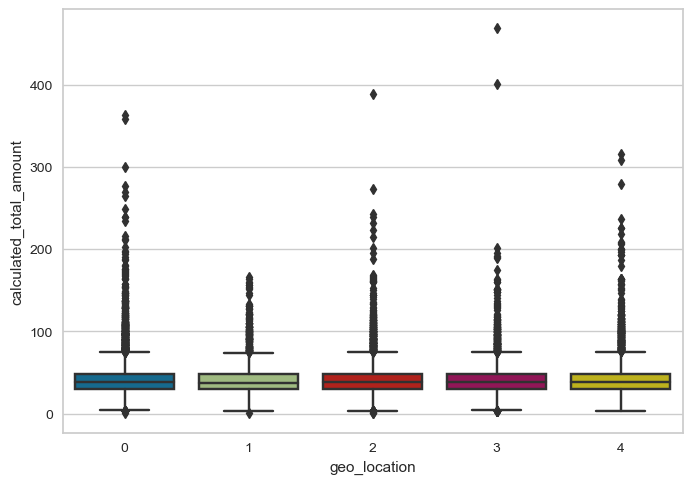

In [117]:
sns.boxplot(x = data['geo_location'], y = data['calculated_total_amount']);

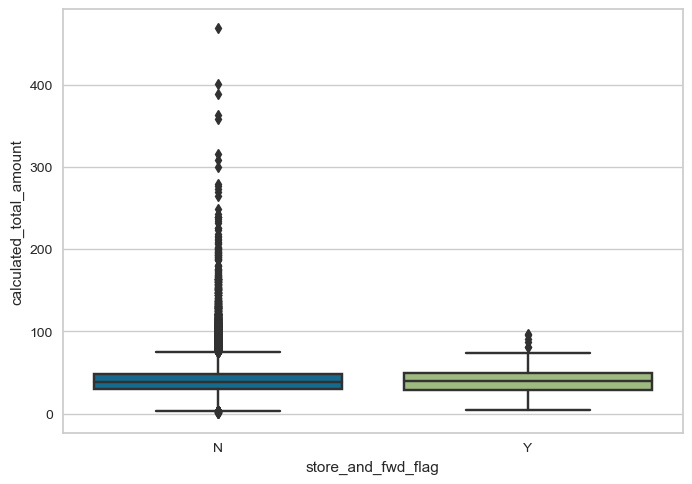

In [121]:
sns.boxplot(x = data['store_and_fwd_flag'], y = data['calculated_total_amount']);

In [125]:
# Trip_count basis rate code
data['trip_count_rate_code'] = data.groupby(by = 'rate_code')['calculated_total_amount'
                                                             ].transform('nunique')
data['avg_amt_rate_code'] = data.groupby(by = 'rate_code')['calculated_total_amount'
                                                             ].transform('mean')
data['median_amt_rate_code'] = data.groupby(by = 'rate_code')['calculated_total_amount'
                                                             ].transform('median')
data['min_amt_rate_code'] = data.groupby(by = 'rate_code')['calculated_total_amount'
                                                             ].transform('min')
data['max_amt_rate_code'] = data.groupby(by = 'rate_code')['calculated_total_amount'
                                                             ].transform('max')

In [131]:
# Basis payment Type
data['trip_count_pmt_type'] = data.groupby(by = 'payment_type')['calculated_total_amount'
                                                             ].transform('nunique')
data['avg_amt_pmt_type'] = data.groupby(by = 'payment_type')['calculated_total_amount'
                                                             ].transform('mean')
data['median_amt_pmt_type'] = data.groupby(by = 'payment_type')['calculated_total_amount'
                                                             ].transform('median')
data['min_amt_pmt_type'] = data.groupby(by = 'payment_type')['calculated_total_amount'
                                                             ].transform('min')
data['max_amt_pmt_type'] = data.groupby(by = 'payment_type')['calculated_total_amount'
                                                             ].transform('max')

In [135]:
# miles per hour
data['trip_duration_hours'] = data['trip_duration']/3600

data['miles_per_hour'] = data['trip_distance']/data['trip_duration_hours']

In [146]:
# Splitting the data
newtrain = data.iloc[:train_data.shape[0],:]
newtest = data.iloc[train_data.shape[0]:,:]

newtrain.shape, newtest.shape

((35000, 44), (15000, 44))

In [147]:
X = newtrain.drop(columns = 'calculated_total_amount', axis = 1)
y = newtrain['calculated_total_amount']

In [164]:
# Let's verify all the columns Statistically
num_cols = ['trip_distance', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'imp_surcharge',
       'total_amount', 'trip_duration','amount_per_mile', 'day_mean', 'day_median', 'day_min',
       'day_max', 'month_mean', 'month_median', 'month_min', 'month_max',
       'trip_count', 'trip_count_rate_code',
       'avg_amt_rate_code', 'median_amt_rate_code', 'min_amt_rate_code',
       'max_amt_rate_code', 'trip_count_pmt_type', 'avg_amt_pmt_type',
       'median_amt_pmt_type', 'min_amt_pmt_type', 'max_amt_pmt_type',
       'trip_duration_hours', 'miles_per_hour']

important_columns = []

for i in num_cols:
    test_test, p_value = stats.ttest_ind(X[i],y)
    if(p_value < 0.05):
        # print(i)
        important_columns.append(i)
    else:
        pass

In [176]:
cat_cols = ['rate_code','store_and_fwd_flag','peak_hour','geo_location','payment_type']

model = sfa.ols('calculated_total_amount~rate_code+store_and_fwd_flag+peak_hours+geo_location+payment_type'
               ,data = newtrain).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
store_and_fwd_flag,1.0,3.789820e+02,378.982032,1.033329,3.093850e-01
rate_code,1.0,1.768833e+03,1768.832509,4.822884,2.809085e-02
peak_hours,1.0,1.905933e+02,190.593255,0.519670,4.709873e-01
geo_location,1.0,3.992231e+01,39.922315,0.108852,7.414571e-01
payment_type,1.0,2.106037e+04,21060.366997,57.423025,3.601301e-14
Residual,34994.0,1.283434e+07,366.758232,NaN,NaN


In [181]:
X = newtrain.loc[:, important_columns]
X['rate_code'] = newtrain['rate_code']
X['payment_type'] = newtrain['payment_type']

In [185]:
newtest = newtest.loc[:, X.columns]

In [190]:
robust = RobustScaler()

# train
scaled_x = robust.fit_transform(X)
scaled_x = pd.DataFrame(scaled_x, columns = X.columns)

# test
scaled_test = robust.transform(newtest)
scaled_test = pd.DataFrame(scaled_test, columns = newtest.columns)

In [194]:
scaled_x.drop(columns = ['rate_code','payment_type'], axis = 1, inplace = True)
scaled_x['rate_code'] = X['rate_code']
scaled_x['payment_type'] = X['payment_type']

scaled_test.drop(columns = ['rate_code','payment_type'], axis = 1, inplace = True)
scaled_test['rate_code'] = newtest['rate_code']
scaled_test['payment_type'] = newtest['payment_type']

In [218]:
# Model

def base_model():
    models = dict()
    models['lr'] = LinearRegression()
    models['dtree'] = DecisionTreeRegressor()
    models['rf'] = RandomForestRegressor()
    models['xgb'] = XGBRegressor()
    models['gdm'] = GradientBoostingRegressor()
    return models


In [219]:
# function to evaluate the models

def eval_models(model):
    cv = KFold(n_splits = 5, shuffle = True, random_state = 1001)
    scores = abs(cross_val_score(estimator = model, X = scaled_x, y = y, cv = cv, 
                            scoring = 'neg_mean_squared_error', n_jobs = -1))
    return scores    

In [220]:
# Let's use to function to calculate the scores

models = base_model()

result, names = list(), list()

for name, models in models.items():
    final_score = eval_models(models)
    result.append(final_score)
    names.append(name)
    print(name, np.mean(result))

lr 367.24322247970633
dtree 598.2589415355674
rf 527.2369076336711
xgb 494.9237389897163
gdm 469.6604621391368


In [232]:
sns.boxplot(x = names, y = result)

TypeError: Neither the `x` nor `y` variable appears to be numeric.

In [223]:
gbm = GradientBoostingRegressor()
xgb = XGBRegressor()
stack = StackingRegressor(estimators = [('gbm', gbm), ('xgb',xgb)], 
                          final_estimator = LinearRegression(), cv = 5)

predictions = stack.fit(scaled_x, y).predict(scaled_test)

In [230]:
submission = pd.DataFrame(predictions, columns = ['calculated_total_amount'])
submission.to_csv('hamari_taxi.csv', index = False)